In [1]:
import os
import sys

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=False, categories_reduced=False
)
# jobs.head()

In [2]:
jobs = jobs[
    (jobs["Description"] != "Nicht stepstone")
    & (jobs["Description"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Description"] != "")
    & (jobs["Profile"] != "")
]
texts = jobs["Description"] + jobs["Profile"]

In [3]:
import pickle
import re

import nltk
from HanTa import HanoverTagger as ht
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def tokenize_doc(doc):
    stopwords_ger = stopwords.words("german")
    stopwords_ger.extend(["du", "sie"])
    stopwords_en = stopwords.words("english")

    cleaned = re.sub(
        r"[\W](?=\w)",
        " ",
        doc.replace("\u200b", " ")
        .replace("\xad", "")
        .replace("-", " ")
        .replace("/", " ")
        .replace("·", " ")
        .replace("•", " ")
        .replace("…", " "),
    )
    tokenized = word_tokenize(cleaned, language="german")
    alphas = [w.lower() for w in tokenized if w.isalpha()]

    tagger = ht.HanoverTagger("morphmodel_ger.pgz")

    no_stops_de = [w for w in alphas if w not in stopwords_ger]
    no_stops_de_en = [w for w in no_stops_de if w not in stopwords_en]

    lemmatized = [tagger.analyze(token)[0].lower() for token in no_stops_de_en]

    return lemmatized

In [5]:
if os.path.isfile("../data/lemmatized_desc_profile.pkl"):
    with open("../data/lemmatized_desc_profile.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

In [6]:
if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas

    with open("../data/lemmatized_docs.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 15675 documents
500/15675
1000/15675
1500/15675
2000/15675
2500/15675
3000/15675
3500/15675
4000/15675
4500/15675
5000/15675
5500/15675
6000/15675
6500/15675
7000/15675
7500/15675
8000/15675
8500/15675
9000/15675
9500/15675
10000/15675
10500/15675
11000/15675
11500/15675
12000/15675
12500/15675
13000/15675
13500/15675
14000/15675
14500/15675
15000/15675
15500/15675


In [7]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('sowie', 20235),
 ('data', 16403),
 ('team', 15273),
 ('gut', 14268),
 ('bereich', 13097),
 ('erfahrung', 11461),
 ('kenntnis', 9702),
 ('haben', 9127),
 ('management', 9031),
 ('studium', 8527)]

In [8]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

dictionary = Dictionary(lemmas)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmas]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# BOW

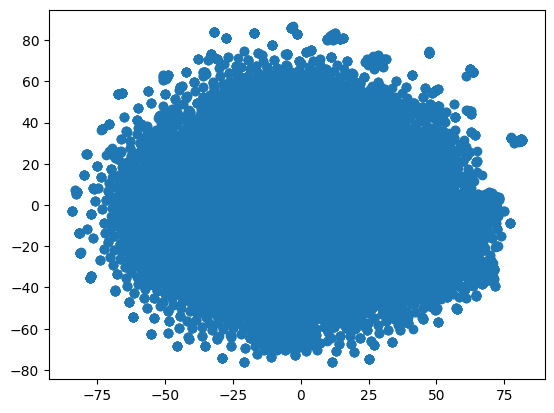

In [9]:
import matplotlib.pyplot as plt
from gensim import matutils
from sklearn.manifold import TSNE

sklearn_vectors = matutils.corpus2csc(bow_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [10]:
import pyLDAvis
import pyLDAvis.gensim
from gensim.models.ldamulticore import LdaMulticore

lda_model = LdaMulticore(
    corpus=bow_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=5,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.215680 -0.020589       1        1  42.417217
1     -0.256067 -0.253416       2        1  25.096145
3      0.129462 -0.083225       3        1  17.808555
2      0.170829  0.100224       4        1  12.625272
0     -0.259905  0.257006       5        1   2.052811, topic_info=            Term          Freq         Total Category  logprob  loglift
22          data  16631.000000  16631.000000  Default  30.0000  30.0000
280    marketing   2400.000000   2400.000000  Default  29.0000  29.0000
181   experience   6771.000000   6771.000000  Default  28.0000  28.0000
132        haben   9372.000000   9372.000000  Default  27.0000  27.0000
517      digital   3725.000000   3725.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
236     customer    230.263155   2629.135775   Topic5  -5.1544   1.4508
2370   strategie    187.612691   1525.912035   Topic5  -5.3592   1.7900
318          web    134.161443    769.931977   Topic5  -5.6946   2.1387
216         tool    147.876257   4127.736070   Topic5  -5.5972   0.5569
558     analytic    134.958531   3007.019737   Topic5  -5.6887   0.7822

[382 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2498      3  0.996148           abap
221       1  0.886639  abgeschlossen
221       3  0.103704  abgeschlossen
221       4  0.009671  abgeschlossen
162       2  0.999482        ability
...     ...       ...            ...
507       1  0.573039     übernehmen
507       3  0.155687     übernehmen
507       4  0.271045     übernehmen
106       1  0.996912     überwachen
1311      1  0.999590    überwachung

[623 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

In [11]:
def calc_topic_for_doc(doc):
    values = []
    tuples = lda_model.get_document_topics(doc)
    for tuple in tuples:
        values.append(tuple[1])
    max_prob = max(values)
    topic = tuples[values.index(max_prob)][0]
    return topic + 1

In [12]:
bow_topic_list = []
for doc in bow_corpus:
    bow_topic_list.append(calc_topic_for_doc(doc))

df_bow = pd.DataFrame(
    {"topics": bow_topic_list, "Job_Kategorie": jobs["Job Kategorie"]}, index=jobs.index
)

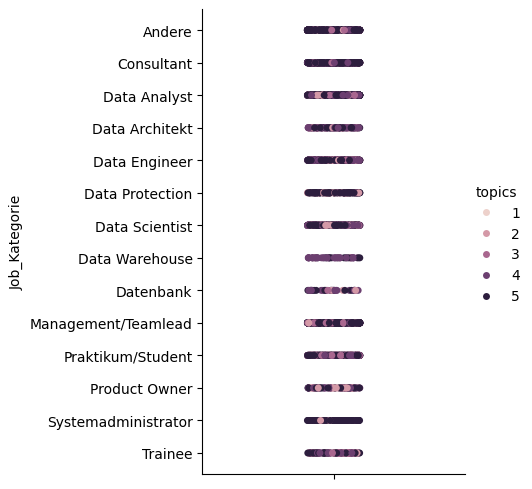

In [13]:
import seaborn as sns

sns.catplot(data=df_bow, hue="topics", y="Job_Kategorie")

# TF-IDF

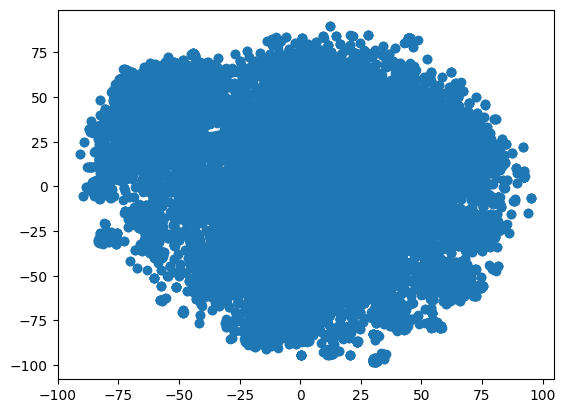

In [14]:
sklearn_vectors = matutils.corpus2csc(tfidf_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [15]:
lda_model = LdaMulticore(
    corpus=tfidf_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=3,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.151781 -0.003580       1        1  74.903480
0     -0.085856 -0.039099       2        1  20.726003
1     -0.065925  0.042679       3        1   4.370517, topic_info=                             Term        Freq       Total Category  logprob  \
181                    experience   52.000000   52.000000  Default  30.0000   
22                           data  144.000000  144.000000  Default  29.0000   
1192                      project   42.000000   42.000000  Default  28.0000   
1211                  development   47.000000   47.000000  Default  27.0000   
19                       business   97.000000   97.000000  Default  26.0000   
...                           ...         ...         ...      ...      ...   
93730  vertriebspartnernallgemein    0.254996    1.251266   Topic3  -9.9947   
93731             zebrastreifendu    0.254996    1.251266   Topic3  -9.9947   
93732                    ziehendu    0.254996    1.251266   Topic3  -9.9947   
93733              überblicktrotz    0.254996    1.251266   Topic3  -9.9947   
93734                   übersehen    0.254996    1.251266   Topic3  -9.9947   

       loglift  
181    30.0000  
22     29.0000  
1192   28.0000  
1211   27.0000  
19     26.0000  
...        ...  
93730   1.5396  
93731   1.5396  
93732   1.5396  
93733   1.5396  
93734   1.5396  

[169 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
221        1  1.001750    abgeschlossen
162        2  1.010536          ability
2679       2  0.980876            acros
3          1  0.977678          analyse
3          2  0.017939          analyse
...      ...       ...              ...
104        1  0.994638                z
93731      1  0.799191  zebrastreifendu
93732      1  0.799191         ziehendu
93733      1  0.799191   überblicktrotz
93734      1  0.799191        übersehen

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [16]:
tfidf_topic_list = []
for doc in tfidf_corpus:
    tfidf_topic_list.append(calc_topic_for_doc(doc))

df_tfidf = pd.DataFrame(
    {"topics": tfidf_topic_list, "Job_Kategorie": jobs["Job Kategorie"]},
    index=jobs.index,
)

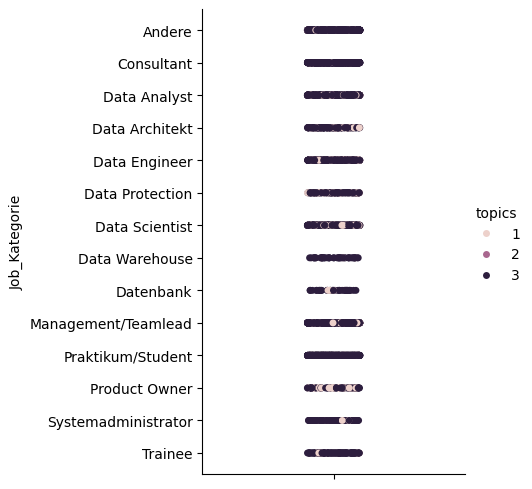

In [17]:
sns.catplot(data=df_tfidf, hue="topics", y="Job_Kategorie")